In [1]:
import mne
import pandas as pd
import numpy as np
from statsmodels.tsa.ar_model import AutoReg
import matplotlib.pyplot as plt
from scipy.signal import csd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="scipy.signal")

from data_preprocessing import preprocess

In [27]:
""" The results of this code were not used in the final presentation because they did not yeild what we wanted: the surrogate data was 
almost identical to the original data, therefore it could not be used for null hypothesis testing.""" 

' The results of this code were not used in the final presentation because they did not yeild what we wanted: the surrogate data was \nalmost identical to the original data, therefore it could not be used for null hypothesis testing.'

In [2]:
#Data Frame from Original Data
df1 = preprocess()

In [18]:
df1

,id,schizo,region,eeg_data,freqs,power,freqs_theta,power_theta,freqs_alpha,power_alpha,freqs_beta,power_beta
0,S164W1,0,F7,"[9.48, 109.94, 308.96, 348.76, 269.15, 208.5, ...","[0.0, 0.016666666666666666, 0.0333333333333333...","[158498.64, 22861.23246172353, 50204.591134708...","[4.0, 4.016666666666667, 4.033333333333333, 4....","[12653.158544343263, 48354.997824733204, 69015...","[8.0, 8.016666666666666, 8.033333333333333, 8....","[26122.060497561743, 20216.5499335299, 26479.2...","[12.0, 12.016666666666666, 12.033333333333333,...","[67789.7194050899, 53651.184341372245, 14663.9..."
1,S164W1,0,F3,"[-151.64, 9.48, 259.68, 318.44, 348.76, 299.48...","[0.0, 0.016666666666666666, 0.0333333333333333...","[136455.69, 8409.359229225813, 38949.763344850...","[4.0, 4.016666666666667, 4.033333333333333, 4....","[17616.150835440894, 92822.94521800872, 35753....","[8.0, 8.016666666666666, 8.033333333333333, 8....","[65223.81328197708, 17790.704272697334, 33462....","[12.0, 12.016666666666666, 12.033333333333333,...","[85636.12307327497, 62779.9895762081, 20635.89..."
2,S164W1,0,F4,"[159.22, 339.29, 519.36, 458.7, 189.55, 58.76,...","[0.0, 0.016666666666666666, 0.0333333333333333...","[52183.59, 26054.72511793837, 48306.3943627817...","[4.0, 4.016666666666667, 4.033333333333333, 4....","[27350.13037720737, 103035.31741294809, 23361....","[8.0, 8.016666666666666, 8.033333333333333, 8....","[40306.14337473731, 8689.729016518411, 5398.53...","[12.0, 12.016666666666666, 12.033333333333333,...","[41202.881615130245, 37928.20118507876, 27839...."
3,S164W1,0,F8,"[259.68, 318.44, 358.24, 259.68, 9.48, -130.79...","[0.0, 0.016666666666666666, 0.0333333333333333...","[81490.68000000001, 11867.360341841628, 57344....","[4.0, 4.016666666666667, 4.033333333333333, 4....","[28052.33049531209, 98464.64021492765, 31475.6...","[8.0, 8.016666666666666, 8.033333333333333, 8....","[56663.7473308475, 21478.899975593606, 21846.7...","[12.0, 12.016666666666666, 12.033333333333333,...","[34437.71856971881, 42838.963068459416, 21701...."
4,S164W1,0,T3,"[238.83, 399.94, 519.36, 458.7, 149.74, -11.37...","[0.0, 0.016666666666666666, 0.0333333333333333...","[109031.83, 33239.29978913151, 20402.886718539...","[4.0, 4.016666666666667, 4.033333333333333, 4....","[27230.940695474685, 51325.96154059415, 16416....","[8.0, 8.016666666666666, 8.033333333333333, 8....","[38862.85559282637, 32335.96769898448, 19762.8...","[12.0, 12.016666666666666, 12.033333333333333,...","[70277.7158139276, 92763.56711893788, 44459.47..."
...,...,...,...,...,...,...,...,...,...,...,...,...
1339,32w1,1,Pz,"[-40.9, 48.76, 209.21, 158.88, -20.45, -171.46...","[0.0, 0.016666666666666666, 0.0333333333333333...","[42580.31999999999, 40506.371012857475, 43940....","[4.0, 4.016666666666667, 4.033333333333333, 4....","[34075.18981837448, 70944.37290985597, 26477.7...","[8.0, 8.016666666666666, 8.033333333333333, 8....","[65239.84069572714, 53987.6222178226, 100021.2...","[12.0, 12.016666666666666, 12.033333333333333,...","[15972.457940048344, 3323.8153445139715, 10079..."
1340,32w1,1,P4,"[48.76, 169.89, 199.78, 108.54, -61.35, -121.1...","[0.0, 0.016666666666666666, 0.0333333333333333...","[34866.18, 40066.88656466791, 51873.5441644073...","[4.0, 4.016666666666667, 4.033333333333333, 4....","[46741.947048847105, 97860.25136131978, 16064....","[8.0, 8.016666666666666, 8.033333333333333, 8....","[67977.03931829463, 64723.56041221257, 85498.0...","[12.0, 12.016666666666666, 12.033333333333333,...","[5244.455209045493, 17408.245710643827, 18500...."
1341,32w1,1,T6,"[188.76, 248.54, 239.1, 169.89, 48.76, 9.44, 9...","[0.0, 0.016666666666666666, 0.0333333333333333...","[26777.709999999995, 35572.958972712506, 44002...","[4.0, 4.016666666666667, 4.033333333333333, 4....","[43216.979730058716, 61507.74634314921, 49234....","[8.0, 8.016666666666666, 8.033333333333333, 8....","[53962.70201381972, 48058.373818026, 69591.832...","[12.0, 12.016666666666666, 12.033333333333333,...","[17390.29803110395, 21032.11576

In [4]:
def fit_ar_and_calculate_fft(eeg_data, lags=10):
    """Fits an Autoregression model to the original EEG dataset. Uses the "eeg_data" column in our dataframe"""

    # Fit AR model
    eeg_data = pd.Series(eeg_data)
    model = AutoReg(eeg_data, lags=lags).fit()
    fitted_values = model.fittedvalues
    residuals = model.resid

    # Compute FFT on fitted values
    fitted_values_np = np.array(fitted_values)
    fft_result = np.fft.fft(fitted_values_np)
    freqs = np.fft.fftfreq(len(fitted_values_np), 1/128)
    fft_magnitude = np.abs(fft_result)

    # Frequency band slices
    theta_indices = slice(240, 481)  # 4-8 Hz
    alpha_indices = slice(480, 721)  # 8-13 Hz
    beta_indices = slice(720, 1801)  # 13-30 Hz

    return {
        "fitted_values": fitted_values.tolist(),
        "residuals": residuals.tolist(),
        "freqs": freqs.tolist(),
        "power": fft_magnitude.tolist(),
        "freqs_theta": freqs[theta_indices].tolist(),
        "power_theta": fft_magnitude[theta_indices].tolist(),
        "freqs_alpha": freqs[alpha_indices].tolist(),
        "power_alpha": fft_magnitude[alpha_indices].tolist(),
        "freqs_beta": freqs[beta_indices].tolist(),
        "power_beta": fft_magnitude[beta_indices].tolist(),
    }

In [5]:
def create_ar_dataframe(df, lags=10):
    """Creates a new DataFrame based on AR model fitted values and their FFT components, and returns a new pandas Dataframe"""
    ar_data = []

    for index, row in df.iterrows():
        try:
            ar_result = fit_ar_and_calculate_fft(row['eeg_data'], lags=lags)
            ar_data.append({
                "id": row['id'],
                "region": row['region'],
                "schizo": row['schizo'],
                "fitted_values": ar_result["fitted_values"],
                "residuals": ar_result["residuals"],
                "freqs": ar_result["freqs"],
                "power": ar_result["power"],
                "freqs_theta": ar_result["freqs_theta"],
                "power_theta": ar_result["power_theta"],
                "freqs_alpha": ar_result["freqs_alpha"],
                "power_alpha": ar_result["power_alpha"],
                "freqs_beta": ar_result["freqs_beta"],
                "power_beta": ar_result["power_beta"],
            })
        except Exception as e:
            print(f"Error processing row {index}: {e}")

    # Create a new DataFrame
    ar_df = pd.DataFrame(ar_data)
    return ar_df

In [6]:
# Create AR DataFrame
ar_df = create_ar_dataframe(df1, lags=10)

ar_df

,id,region,schizo,fitted_values,residuals,freqs,power,freqs_theta,power_theta,freqs_alpha,power_alpha,freqs_beta,power_beta
0,S164W1,F7,0,"[215.62308133927965, -200.30770415211276, -131...","[-226.99308133927966, 109.32770415211276, 19.3...","[0.0, 0.016688396349413298, 0.0333767926988265...","[156347.3, 19844.09537335932, 45631.3858439125...","[4.005215123859191, 4.021903520208605, 4.03859...","[22688.204209280117, 20516.73945273522, 65076....","[8.010430247718382, 8.027118644067796, 8.04380...","[27283.025332585792, 38006.314317947006, 43242...","[12.015645371577575, 12.032333767926987, 12.04...","[55275.545710483435, 17714.233960862675, 44177..."
1,S164W1,F3,0,"[243.85336139389537, 75.06568110602936, -50.72...","[-44.83336139389536, -25.785681106029358, 50.7...","[0.0, 0.016688396349413298, 0.0333767926988265...","[133985.90999999965, 9626.779673382109, 33906....","[4.005215123859191, 4.021903520208605, 4.03859...","[36609.14210865356, 65240.85704445138, 45248.3...","[8.010430247718382, 8.027118644067796, 8.04380...","[59908.584093047735, 44942.836121770146, 57169...","[12.015645371577575, 12.032333767926987, 12.04...","[70405.86275199366, 23395.03478463953, 29108.4..."
2,S164W1,F4,0,"[77.76285427905442, -185.25479941438817, -400....","[-168.74285427905443, -116.12520058561182, -1....","[0.0, 0.016688396349413298, 0.0333767926988265...","[50231.24999999993, 25240.920975283338, 44164....","[4.005215123859191, 4.021903520208605, 4.03859...","[58334.19051178844, 82549.85220456093, 33985.3...","[8.010430247718382, 8.027118644067796, 8.04380...","[35905.82028922236, 30330.37044918421, 51674.6...","[12.015645371577575, 12.032333767926987, 12.04...","[40727.22568238982, 27040.777438343186, 25809...."
3,S164W1,F8,0,"[71.53421675069134, -377.8739260814936, -516.9...","[-272.45421675069133, -42.91607391850641, -74....","[0.0, 0.016688396349413298, 0.0333767926988265...","[80580.84999999992, 11549.626523986319, 53097....","[4.005215123859191, 4.021903520208605, 4.03859...","[45593.773081177635, 98801.83701412647, 60696....","[8.010430247718382, 8.027118644067796, 8.04380...","[35298.957440079765, 45998.595182571495, 49895...","[12.015645371577575, 12.032333767926987, 12.04...","[41581.35001308214, 25166.498545834176, 22567...."
4,S164W1,T3,0,"[317.95758673932926, -81.87819816712391, -201....","[-238.34758673932924, -9.101801832876092, 30.7...","[0.0, 0.016688396349413298, 0.0333767926988265...","[106461.58999999956, 31114.08999996783, 16400....","[4.005215123859191, 4.021903520208605, 4.03859...","[18582.338486828536, 40218.62875751735, 24550....","[8.010430247718382, 8.027118644067796, 8.04380...","[46101.64167848023, 18291.909352221217, 37919....","[12.015645371577575, 12.032333767926987, 12.04...","[93912.21836852813, 39952.471327444204, 74183...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1339,32w1,Pz,1,"[-142.8215303498504, -11.39186676190117, 53.79...","[51.58153034985041, -20.06813323809883, -53.79...","[0.0, 0.016688396349413298, 0.0333767926988265...","[43399.88000000017, 38071.4572067921, 40051.01...","[4.005215123859191, 4.021903520208605, 4.03859...","[29844.489934883568, 54869.66773280156, 8329.2...","[8.010430247718382, 8.027118644067796, 8.04380...","[102368.9348637941, 70394.00988160465, 29254.0...","[12.015645371577575, 12.032333767926987, 12.04...","[2515.758466802801, 12813.324780135026, 22498...."
1340,32w1,P4,1,"[1.5732135002816943, 50.26193468775408, 1.1795...","[7.866786499718305, -70.71193468775408, -1.179...","[0.0, 0.016688396349413298, 0.0333767926988265...","[35084.83000000017, 37316.32569075776, 47823.5...","[4.005215123859191, 4.021903520208605, 4.03859...","[65553.195926078, 70977.28643291703, 23811.152...","[8.010430247718382, 8.027118644067796, 8.04380...","[101202.9468954074, 45789.54733862076, 52456.9...","[12.015645371577575, 12.032333767926987, 12.04...","[15169.514611116405, 22256.918679449725, 30593..."
1341,32w1,T6,1,"[125.84260233603007, 133.112757273173, 110.005...","[-6.29260233

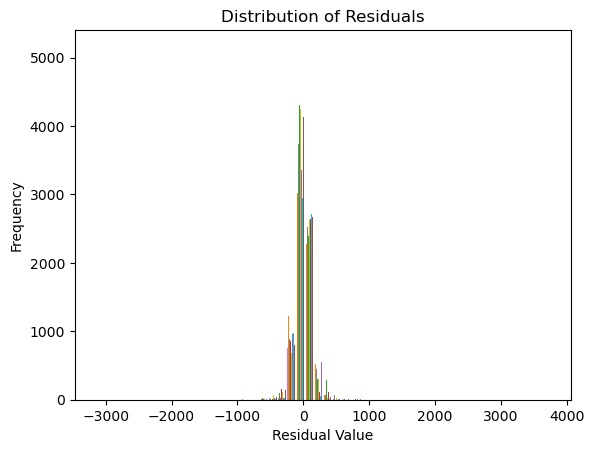

In [13]:
residuals = ar_df['residuals']

plt.hist(residuals, bins=50)
plt.title('Distribution of Residuals')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.show()

In [18]:
def cross_spectral_matrix(patient_id, wave_option='power_beta', surrogate=False):
    # Filter data for the selected patient
    patient_data = df1[df1['id'] == patient_id]

    # Create an empty list to hold the power data for each region
    power_data = []

    sampling_freq = 128

    # Loop through the regions and extract power data
    for region in patient_data['region'].unique():
        # Filter power data for the current region
        region_data = patient_data[patient_data['region'] == region]
        power_data.append(region_data[wave_option].values[0])  

    power_df = pd.DataFrame(power_data).transpose() 

    # Check for missing values and replace them with 0
    if power_df.isnull().values.any():
        print(f"Warning: Missing values detected in power data for patient {patient_id}")
        power_df = power_df.fillna(0)  

    channels = power_df.columns
    csd_matrix = np.zeros((len(channels), len(channels)), dtype=complex)

    #Compute CSD Matrix
    for i, ch1 in enumerate(channels):
        for j, ch2 in enumerate(channels):
            # Compute CSD between two channels
            freqs, csd_values = csd(power_df[ch1], power_df[ch2], fs=sampling_freq, nperseg=256)
            
            # Take the average value of the CSD 
            csd_matrix[i, j] = np.mean(csd_values)

    #Normalize CSD Matrix
    for i in range(len(channels)):
        for j in range(len(channels)):
            if i != j:
                csd_matrix[i, j] = csd_matrix[i, j] / np.sqrt(csd_matrix[i, i] * csd_matrix[j, j])
    
    np.fill_diagonal(csd_matrix, 1) #I explicitly set the diagonals to 1, because when computing the average across patients, i take the magnitude of the average csd matrix and it messes it up
    # Return the CSD matrix
    return csd_matrix, freqs

In [19]:
def average_csd(patient_ids, wave_option='power_beta'):
    csd_sums = None
    count = 0

    # Loop through each patient and calculate their CSD matrix
    for patient_id in patient_ids:
        csd_matrix, _ = cross_spectral_matrix(patient_id, wave_option)  

    # Add the current CSD matrix to the cumulative sum
        if csd_sums is None:
            csd_sums = csd_matrix
        else:
            csd_sums += csd_matrix

        count += 1

    # Calculate the average CSD matrix
    average_csd_matrix = np.abs(csd_sums / count) 

    region_labels = ["F7", "F3", "F4", "F8", "T3", "C3", "Cz", "C4", "T4", "T5", "P3", "Pz", "P4", "T6", "O1", "O2"]
    average_csd_df = pd.DataFrame(average_csd_matrix, columns=region_labels, index=region_labels)

    return average_csd_df

In [20]:
def plot_correlation_matrices(healthy_patients, schizo_patients, wave_option='power_beta', ax=None):
    # Calculate average correlation matrices for both healthy and schizophrenic patients
    avg_corr_healthy = average_csd(healthy_patients, wave_option=wave_option)
    avg_corr_schizo = average_csd(schizo_patients, wave_option=wave_option)
    
    # Compute the global vmin and vmax for consistent color scaling
    global_vmin = min(avg_corr_healthy.min().min(), avg_corr_schizo.min().min())
    global_vmax = max(avg_corr_healthy.max().max(), avg_corr_schizo.max().max())

    corr_difference = avg_corr_healthy - avg_corr_schizo
    
    diff_vmin = 0.06  
    diff_vmax = 0.175

    sns.heatmap(avg_corr_healthy, annot=False, cmap='Oranges', fmt='.2f', xticklabels=True, yticklabels=True,vmin=global_vmin, vmax=global_vmax, ax=ax[0])
    ax[0].set_title(f"Healthy Patients ({wave_option.capitalize()})")
    sns.heatmap(avg_corr_schizo, annot=False, cmap='Oranges', fmt='.2f', xticklabels=True, yticklabels=True,vmin=global_vmin, vmax=global_vmax, ax=ax[1])
    ax[1].set_title(f"Schizophrenic Patients ({wave_option.capitalize()})")
    sns.heatmap(corr_difference, annot=False, cmap='Oranges', fmt='.2f', xticklabels=True, yticklabels=True,vmin=diff_vmin, vmax=diff_vmax, ax=ax[2])
    ax[2].set_title("Difference (Healthy - Schizophrenic)")

    for axis in ax:
        axis.set_xlabel('Regions (Channels)')
        axis.set_ylabel('Regions (Channels)')

In [21]:
healthy_patients = ar_df[ar_df['schizo'] == 0]['id'].unique().tolist()
schizo_patients = ar_df[ar_df['schizo'] == 1]['id'].unique().tolist()

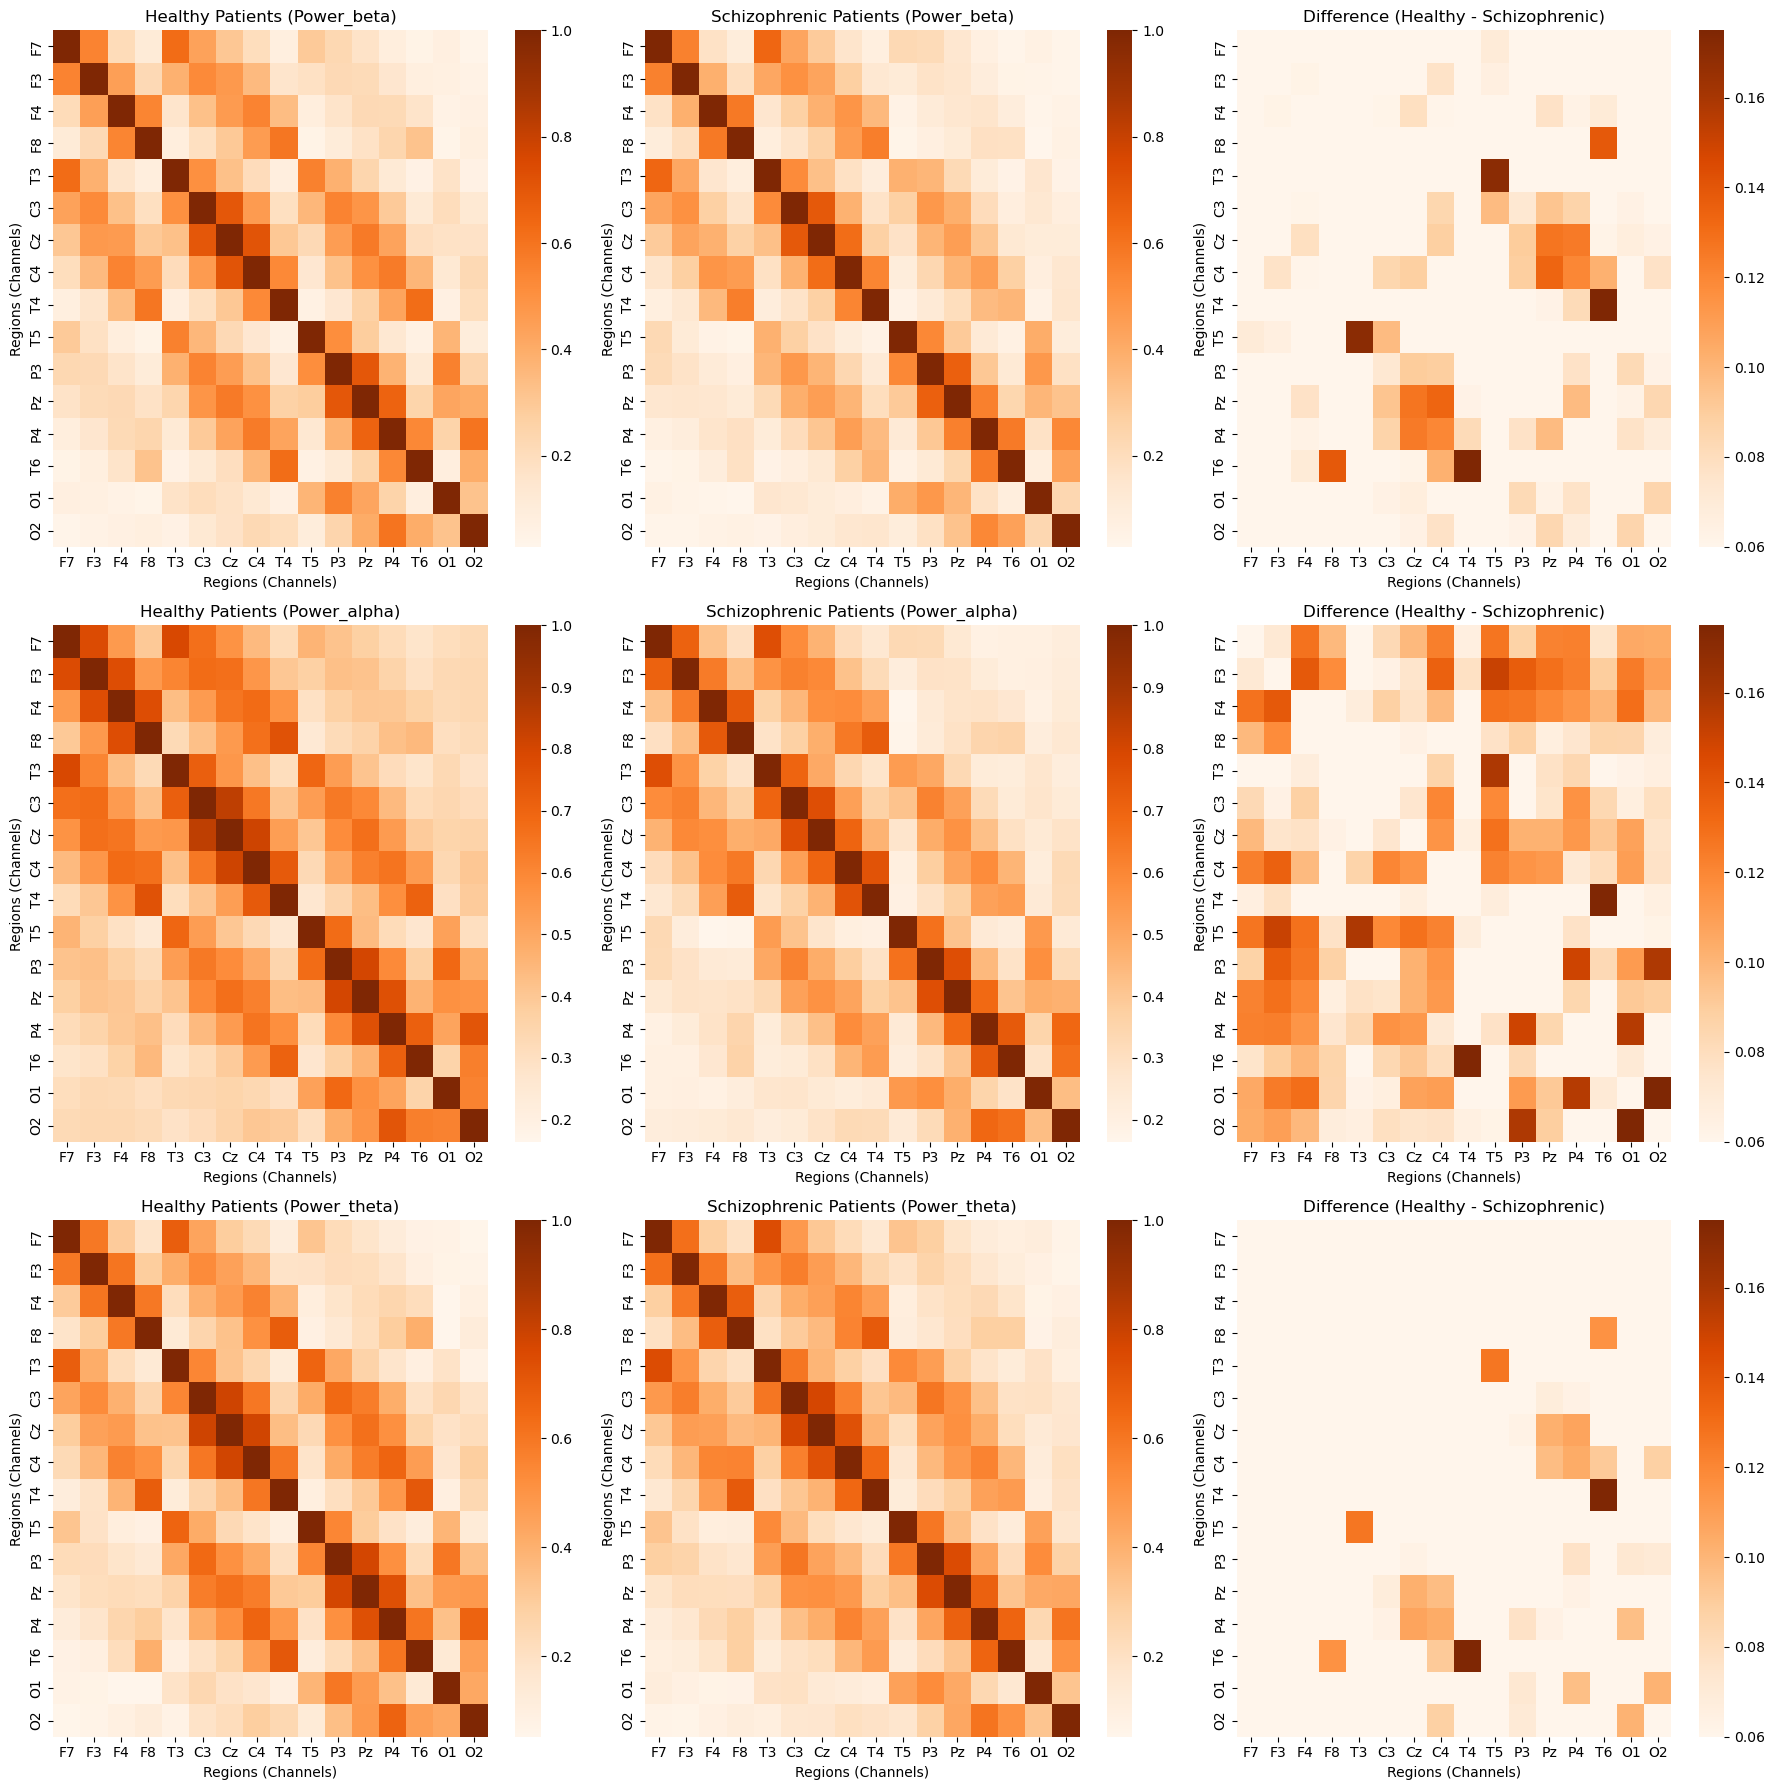

In [22]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))

# Plot for beta
plot_correlation_matrices(healthy_patients, schizo_patients, wave_option='power_beta', ax=axes[0])

# Plot for alpha
plot_correlation_matrices(healthy_patients, schizo_patients, wave_option='power_alpha', ax=axes[1])

# Plot for theta
plot_correlation_matrices(healthy_patients, schizo_patients, wave_option='power_theta', ax=axes[2])

plt.tight_layout()
plt.show()

In [23]:
# Compute surrogate data for AR Model by shuffling residuals
def compute_surrogate_data(patient_ids, lags=10):
    surrogate_data = {}

    for patient_id in patient_ids:
        patient_data = ar_df[ar_df['id'] == patient_id]
        patient_surrogate = {}

        for region in patient_data['region'].unique():
            region_data = patient_data[patient_data['region'] == region]

            # Extract residuals and fitted values
            residual_data = region_data['residuals'].values[0]
            fitted_values = region_data['fitted_values'].values[0]

            # Shuffle residuals and generate surrogate data
            shuffled_residuals = np.random.permutation(residual_data)
            surrogate_data_values = np.array(fitted_values) + shuffled_residuals

        
            # Store surrogate data for this region
            patient_surrogate[region] = surrogate_data_values

        # Save surrogate data for this patient
        surrogate_data[patient_id] = patient_surrogate

    return pd.DataFrame(surrogate_data)


In [24]:
surrogate_healthy = compute_surrogate_data(healthy_patients, lags=10)
surrogate_schizo = compute_surrogate_data(schizo_patients, lags=10)

surrogate_healthy


,S164W1,s20w1,S60W,S182W1,s43w1,S47W1,S26W1,S179W1,S85W1,S167W1,...,S196W1,s12w1,S78W,S153W1,S177W1,s173w1,S72W1,s157w1,s94w1,S155W1
F7,"[260.9305381292612, -51.202347642174686, -125....","[300.2564467874462, 207.87513107851095, 174.52...","[-189.00526248636606, 188.92223324660787, 154....","[339.6242315042447, -55.558155417631426, 6.751...","[-129.6232069673231, 328.1153925952675, 601.33...","[196.18916234302554, 223.16796787509008, 262.9...","[253.83448300520746, 43.51858137433899, -44.92...","[184.98348330264164, 258.5405555703258, 189.53...","[389.81609301583546, 359.8373737744228, 226.66...","[-424.6629345532194, -177.75896679227714, -237...",...,"[328.92080582664687, -63.576395987895054, 137....","[-508.03491129562036, -404.81788422826395, -23...","[81.17982083595558, -22.250333199532335, 99.45...","[-419.09682303094667, 345.02702493124303, 497....","[-116.70619299927208, -103.89026128444155, -22...","[103.00118013088938, 149.1999941280073, 269.72...","[220.34031132035685, 577.1821166222003, 666.98...","[108.13167296684051, -50.034993189690425, -405...","[129.63358541048083, 128.94264961956907, 70.13...","[-16.454417086543685, 160.69209339089758, 163...."
F3,"[308.72892691587015, 68.67076134805444, -61.37...","[374.9205649044195, 240.34947296205144, 256.61...","[-195.808772440196, 22.48561741877607, 62.7081...","[196.78424717490248, 28.84756888288902, -13.12...","[-26.07390774995656, 639.3118775872613, 461.17...","[591.2176015521852, 526.2874573047148, 690.699...","[8.589910721894682, -159.00734546262458, 405.5...","[170.58029577994475, 315.7140540634332, 461.15...","[447.4053744688133, 87.73547324326816, -117.13...","[173.7392621599954, -67.71962076921719, -174.5...",...,"[49.93365188949838, 197.93107040121706, 203.25...","[-365.9787181794971, -438.82689600849744, -238...","[-152.73506461531872, 53.18112421655884, -162....","[-312.9598537982045, 143.04985002875236, 103.9...","[2.5611881237815197, -95.28115985332124, -84.3...","[-208.13384480770026, -312.48018713795346, 51....","[92.19568893153027, 299.4270936585858, 442.754...","[33.34834078028864, -413.55498569355825, -597....","[-157.6277682271921, -71.47942162697578, -27.9...","[616.9524692654602, 890.8382286565127, 733.537..."
F4,"[81.90379001277952, -393.84324232031827, -428....","[-267.50604641034795, -73.17545978884557, -199...","[-18.22424154330296, -89.27841992921358, -295....","[206.4608096651836, 198.6295839768851, 322.110...","[454.60638487985386, 309.57209491272255, 293.3...","[436.2037392679054, 494.15807972650634, 511.11...","[-58.92725468237163, -90.22681725626231, 369.6...","[115.8221290160185, -1.0124965772632493, 218.5...","[134.72088983435842, -104.19532753510492, -176...","[-152.23745655648545, -140.06989526558058, -18...",...,"[184.34725506159725, 323.9707549389295, 697.32...","[-314.9874922555641, -231.50991663802273, -124...","[165.63298041648224, -162.9560649528733, 167.6...","[-46.13806849150406, 586.4383359569476, 519.25...","[-192.58195229464786, -240.56131574504187, -19...","[14.957218363290622, -192.097748480322, -141.1...","[117.71122891324737, 269.5618808452026, 236.30...","[-80.8729571424296, -180.96645728741166, -781....","[-134.23236168559174, -404.31975079618024, -10...","[555.0472511910375, 854.452726191902, 946.5280..."
F8,"[29.696864987176326, -375.2379359857282, -592....","[99.97597219644993, 113.58717633103589, -50.98...","[345.21965660633424, 165.9810674923492, 157.76...","[62.36726366570062, 142.34468227175927, 292.45...","[409.8155042572588, 115.54262093652964, 346.35...","[273.7995226628168, 141.66761817189916, 302.77...","[38.79489642480388, 29.186911914614853, 58.781...","[235.41564199457042, 285.6798716823571, 155.70...","[128.6151505823835, 180.84087937783468, 142.20...","[-222.92004242962318, 226.19113466032948, 6.48...",...,"[426.4610661897853, 292.7922912904686, 395.638...","[-169.06842610482695, -214.24300506538665, -21...","[61.47581590539791, 8.51023244463478, 31.30745...","[9.320012046969453, 372.83099540903396, 23

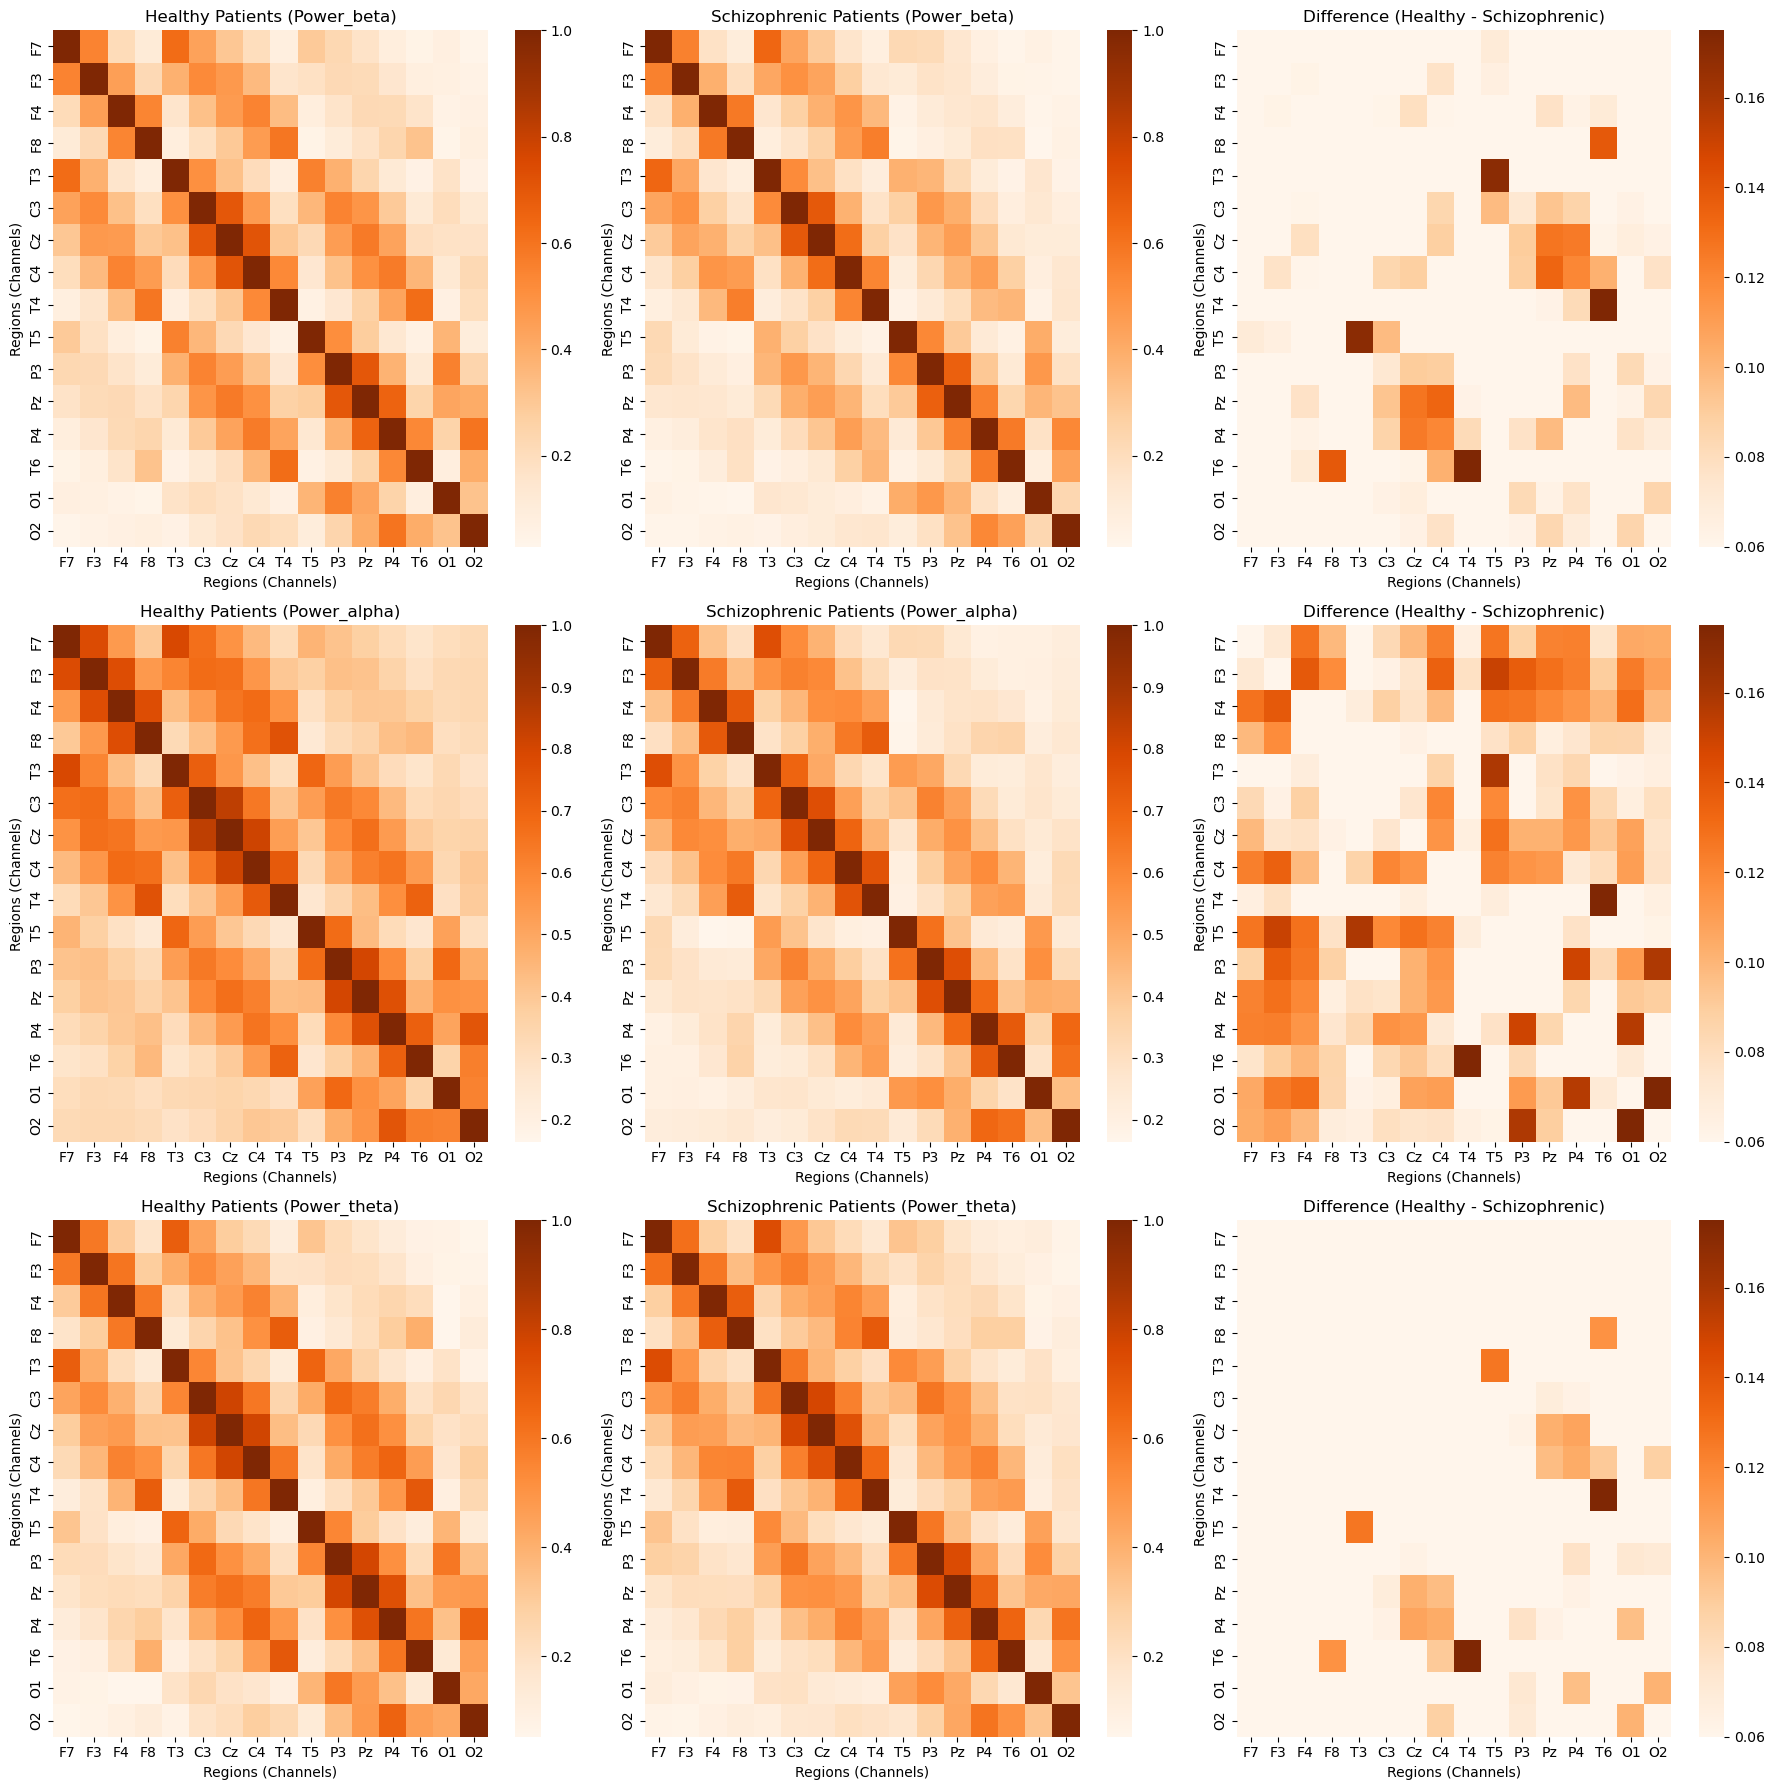

In [24]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))

# Plot for beta
plot_correlation_matrices(surrogate_healthy, surrogate_schizo, wave_option='power_beta', ax=axes[0])

# Plot for alpha
plot_correlation_matrices(surrogate_healthy, surrogate_schizo, wave_option='power_alpha', ax=axes[1])

# Plot for theta
plot_correlation_matrices(surrogate_healthy, surrogate_schizo, wave_option='power_theta', ax=axes[2])

plt.tight_layout()
plt.show()

In [28]:
# Compute a correlation matrix to check whether the surrogate and original data are similar or different enough
def plot_correlation_matrices_surrogate(original_data, surrogate_data, wave_option='power_beta', ax=None):
    # Calculate average correlation matrices for both healthy and schizophrenic patients
    avg_healthy_orig = average_csd(original_data, wave_option=wave_option)
    avg_healthy_sur = average_csd(surrogate_data, wave_option = wave_option)
    
    # Compute the global vmin and vmax for consistent color scaling
    global_vmin = min(avg_healthy_orig.min().min(), avg_healthy_sur.min().min())
    global_vmax = max(avg_healthy_orig.max().max(), avg_healthy_sur.max().max())

    corr_difference = avg_healthy_orig - avg_healthy_sur
    
    diff_vmin = 0.06 
    diff_vmax = 0.175

    # Plot on provided axes
    sns.heatmap(avg_healthy_orig, annot=False, cmap='Oranges', fmt='.2f', xticklabels=True, yticklabels=True,vmin=global_vmin, vmax=global_vmax, ax=ax[0])
    ax[0].set_title(f"Original Data ({wave_option.capitalize()})")
    sns.heatmap(avg_healthy_sur, annot=False, cmap='Oranges', fmt='.2f', xticklabels=True, yticklabels=True,vmin=global_vmin, vmax=global_vmax, ax=ax[1])
    ax[1].set_title(f"Surrogate Data ({wave_option.capitalize()})")
    sns.heatmap(corr_difference, annot=False, cmap='Oranges', fmt='.2f', xticklabels=True, yticklabels=True,vmin=diff_vmin, vmax=diff_vmax, ax=ax[2])
    ax[2].set_title("Difference (Original-Surrogate Data)")

    for axis in ax:
        axis.set_xlabel('Regions (Channels)')
        axis.set_ylabel('Regions (Channels)')

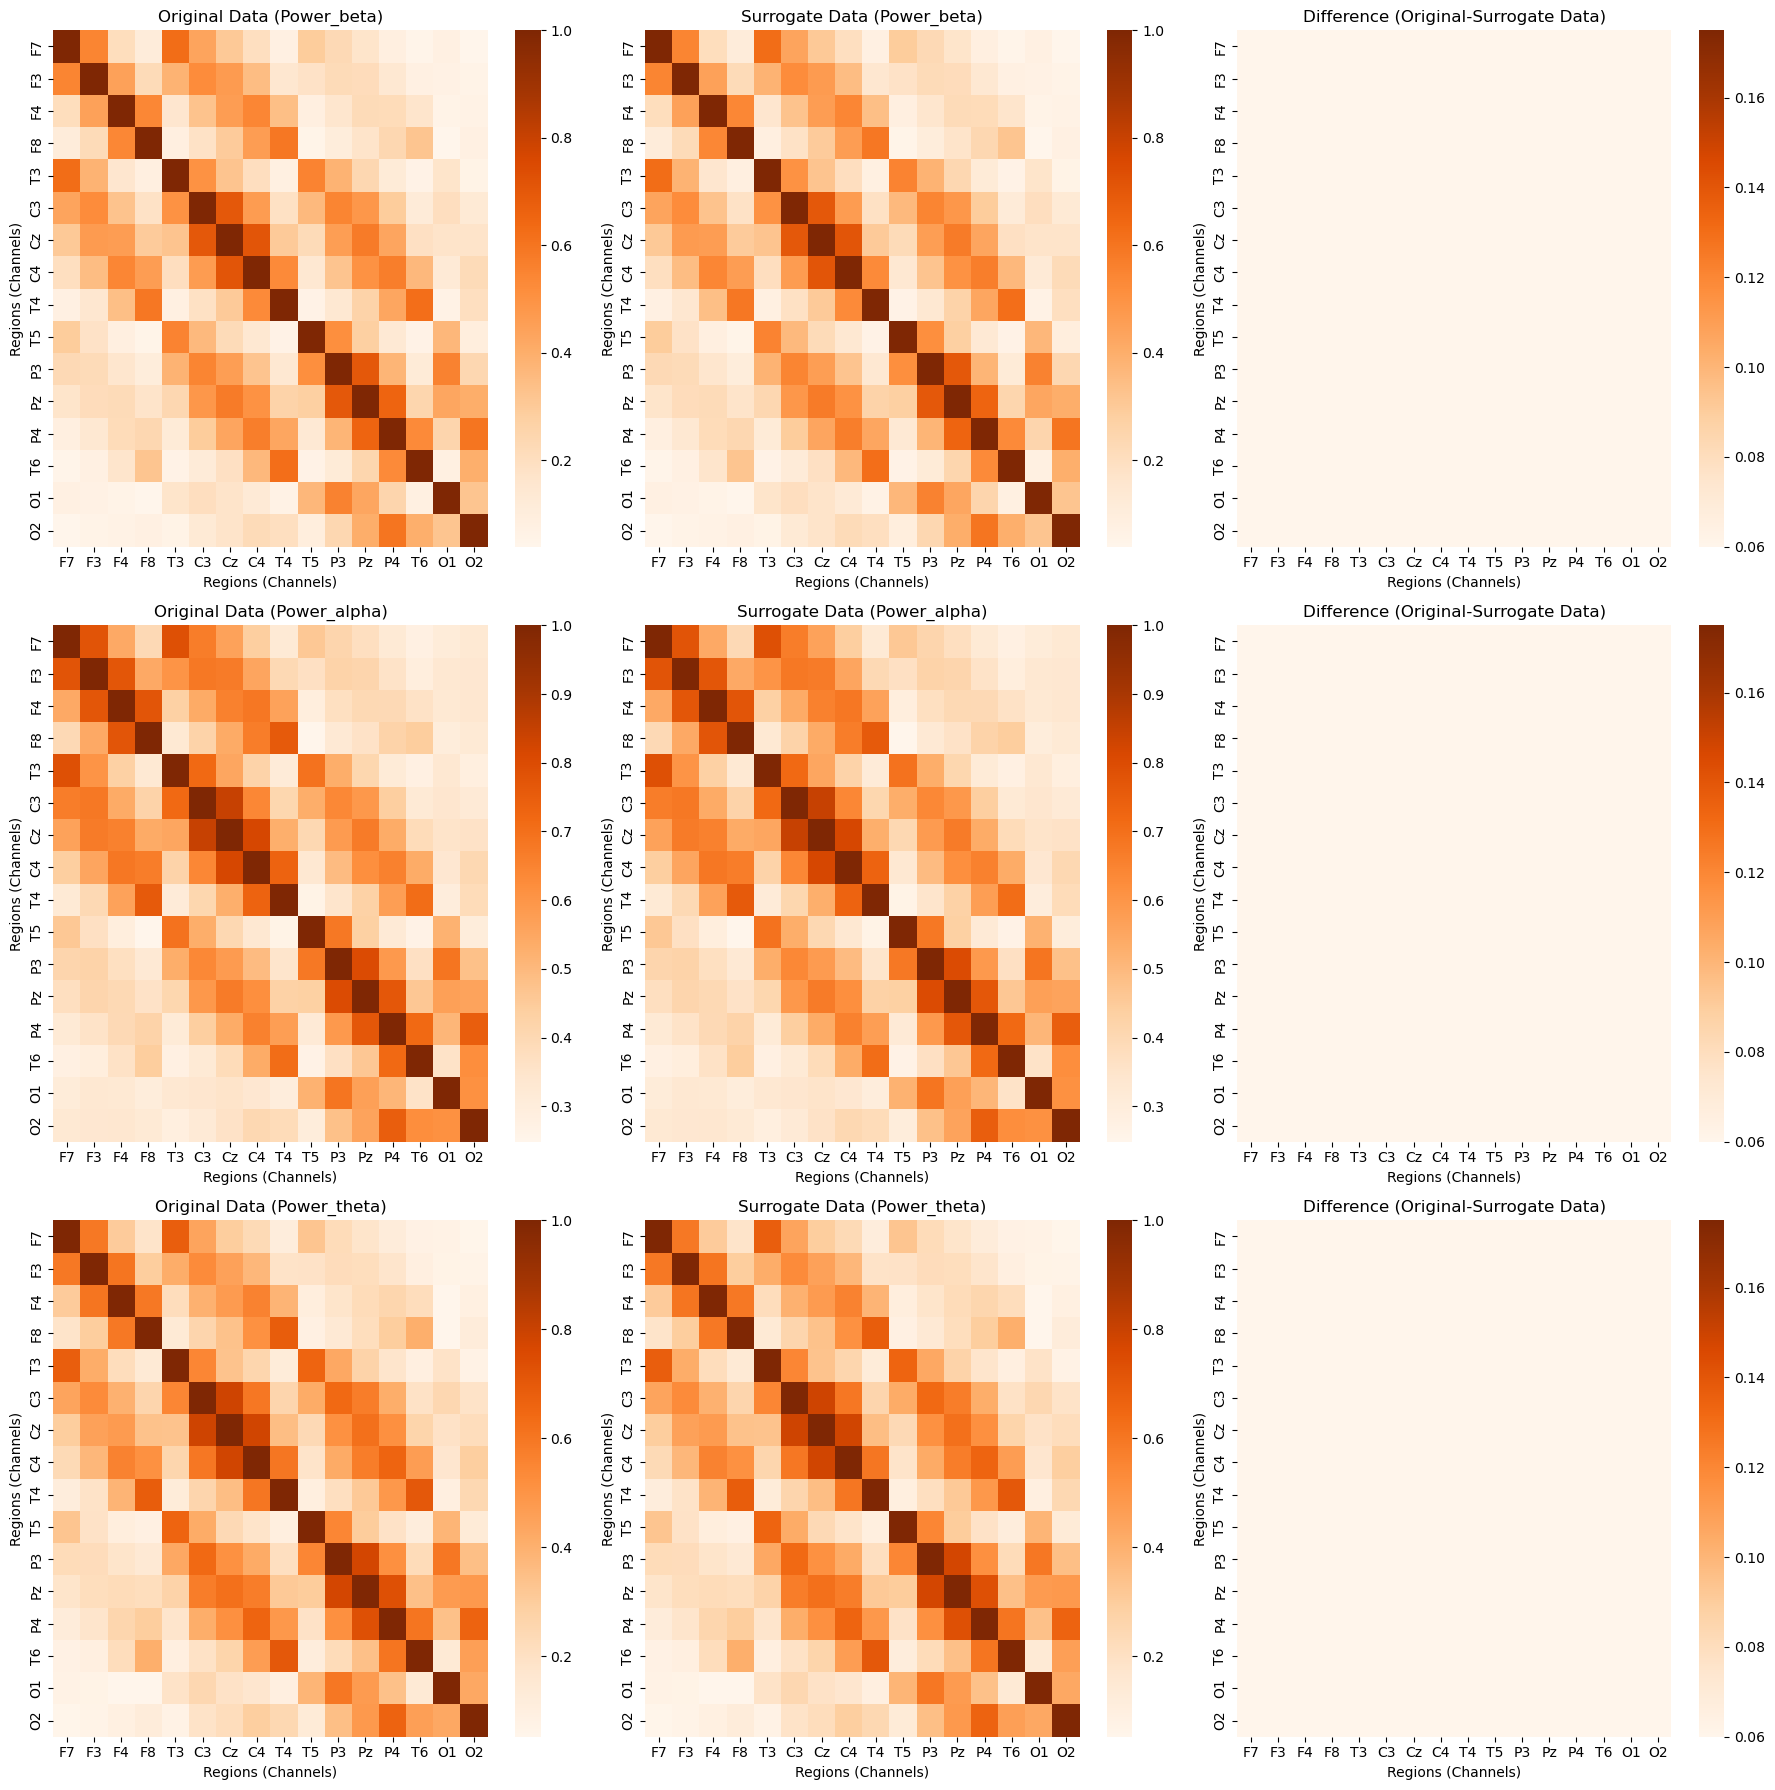

In [31]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))

# Plot for beta
plot_correlation_matrices_surrogate(healthy_patients, surrogate_healthy, wave_option='power_beta', ax=axes[0])

# Plot for alpha
plot_correlation_matrices_surrogate(healthy_patients, surrogate_healthy, wave_option='power_alpha', ax=axes[1])

# Plot for theta
plot_correlation_matrices_surrogate(healthy_patients, surrogate_healthy, wave_option='power_theta', ax=axes[2])

plt.tight_layout()
plt.show()